# Finite strain
[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meyer-nils/torch-fem/blob/main/examples/basic/solid/finite_strain.ipynb)

We compare linear and non-linear geometric models for a cantilever beam subjected to a concentrated force at its tip.

In [1]:
import torch
import pyvista
import matplotlib.pyplot as plt

from torchfem import Solid
from torchfem.mesh import cube_hexa
from torchfem.materials import IsotropicElasticity3D, Hyperelastic3D

# Set default data type to double precision
torch.set_default_dtype(torch.float64)

In [2]:
# Material parameters
E = 1000.0
nu = 0.3
lbd = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))
mu = E / (2.0 * (1.0 + nu))

## Create the beam model

In [3]:
# Define linear elastic small strain material
material = IsotropicElasticity3D(E=E, nu=nu)

# Generate beam
L = 5.0
nodes, elements = cube_hexa(21, 5, 5, L, 1.0, 1.0)
beam = Solid(nodes, elements, material)

# Assign boundary conditions
P = -10.0
tip = (nodes[:, 0] == L) & (nodes[:, 1] == 0.5) & (nodes[:, 2] == 0.5)
beam.constraints[nodes[:, 0] == 0, :] = True
beam.forces[tip, 2] = P

# Increments
increments = torch.linspace(0.0, 1.0, 11)

## Small strain isotropic elasticity without geometric non-linearity

In [4]:
# Solve
u_lg, _, σ_lg, F_lg, _ = beam.solve(increments=increments, return_intermediate=True)

# Show result
beam.plot(
    u=u_lg[-1],
    element_property={"Cauchy stress": σ_lg[-1, :, 0, 0]},
    show_undeformed=True,
)

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

## Saint Venant-Kirchhoff isotropic elasticity with geometric non-linearity


The strain energy function for this Saint Venant-Kirchhoff material is chosen as 

$$
    \psi(C) = \frac{\lambda}{2} \left( \textrm{tr}(E)\right)^2 - \mu \textrm{tr}(E^2)
$$

with the right Cauchy-Green tensor 
$$
    C = F^\top F
$$

and the Green-Lagrange tensor

$$
    E = \frac{1}{2} \left(C - I\right)
$$

In [ ]:
def psi(F):
    """St. Venant-Kirchhoff strain energy density function."""
    # Compute the right Cauchy-Green deformation tensor
    C = F.transpose(-1, -2) @ F
    # Compute Green-Lagrange strain tensor
    E = 0.5 * (C - torch.eye(3))
    return lbd / 2.0 * torch.trace(E) ** 2 + mu * torch.trace(E @ E)

In [6]:
# Change material model
beam.material = Hyperelastic3D(psi)

# Solve
u_ng, _, σ_ng, F_ng, _ = beam.solve(
    increments=increments, return_intermediate=True, nlgeom=True
)

# Show result
beam.plot(
    u=u_ng[-1],
    element_property={"Cauchy stress": σ_ng[-1, :, 0, 0]},
    show_undeformed=True,
)

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

## Comparison

In [7]:
plotter = pyvista.Plotter()
beam.plot(color="gray", plotter=plotter, opacity=0.1)
beam.plot(u=u_lg[-1], color="cyan", opacity=0.8, plotter=plotter)
beam.plot(u=u_ng[-1], color="orange", opacity=0.8, plotter=plotter)
plotter.show(jupyter_backend="html")

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

## Reference solutions 

Simulia Abaqus uses an Updated Lagrangian approach with logarithmic strain and reduced integration, while torch-fem uses a Total Lagrangian approach with the Green-Lagrange strain and full integration here. Therefore, the solutions are not 100% comparable. For moderately large stretches, but large rotations, they should be similar, though.

In [8]:
# Reference time increments
increments_abq = torch.linspace(0.0, 1.0, 11)

# ABAQUS displacements at the tip with linear elastic material and NLGEOM=NO
u_abq_lg = torch.tensor(
    [
        [0.00e-08, 0, -0.0000],
        [0.63e-08, 0, -0.5097],
        [1.26e-08, 0, -1.0195],
        [1.89e-08, 0, -1.5293],
        [2.52e-08, 0, -2.0391],
        [3.16e-08, 0, -2.5489],
        [3.79e-08, 0, -3.0587],
        [4.42e-08, 0, -3.5685],
        [5.05e-08, 0, -4.0782],
        [5.68e-08, 0, -4.5880],
        [6.32e-08, 0, -5.0978],
    ]
)
# ABAQUS displacements at the tip with linear elastic material and NLGEOM=YES
u_abq_ng = torch.tensor(
    [
        [-0.000, 0, -0.00000],
        [-0.029, 0, -0.50353],
        [-0.111, 0, -0.98141],
        [-0.232, 0, -1.41558],
        [-0.377, 0, -1.79791],
        [-0.536, 0, -2.12832],
        [-0.697, 0, -2.41129],
        [-0.856, 0, -2.65328],
        [-1.008, 0, -2.86087],
        [-1.152, 0, -3.03998],
        [-1.288, 0, -3.19567],
    ]
)

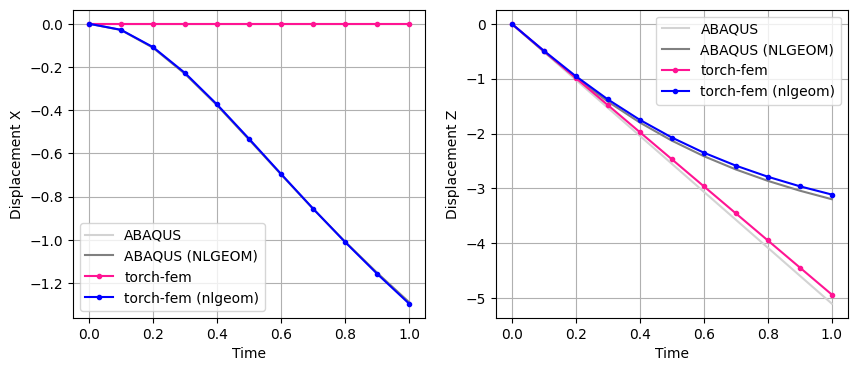

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(increments_abq, u_abq_lg[:, 0], "-", color="lightgray", label="ABAQUS")
ax[0].plot(increments_abq, u_abq_ng[:, 0], "-", color="gray", label="ABAQUS (NLGEOM)")
ax[0].plot(increments, u_lg[:, tip, 0], ".-", color="deeppink", label="torch-fem")
ax[0].plot(increments, u_ng[:, tip, 0], ".-", color="blue", label="torch-fem (nlgeom)")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Displacement X")
ax[0].legend()
ax[0].grid()
ax[1].plot(increments_abq, u_abq_lg[:, 2], "-", color="lightgray", label="ABAQUS")
ax[1].plot(increments_abq, u_abq_ng[:, 2], "-", color="gray", label="ABAQUS (NLGEOM)")
ax[1].plot(increments, u_lg[:, tip, 2], ".-", color="deeppink", label="torch-fem")
ax[1].plot(increments, u_ng[:, tip, 2], ".-", color="blue", label="torch-fem (nlgeom)")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Displacement Z")
ax[1].legend()
ax[1].grid()
plt.show()